Data source: https://radiosondy.info/

https://radiosondy.info/sonde_archive.php?sondenumber=T1231063

last measurement: 2022-03-13 01:51:00z

In [10]:
import io
import csv
import re

data = []
max_altitude = 0

def firstMatch(pattern, string):
    match = re.search(pattern, string)
    if match:
        return match.group(1)
    else:
        return None

with io.open('data.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    
    for row in reader:
        if(row['STATION'] != 'DO4OSS-14'):
            continue

        # Parse description
        # Clb=-4.6m/s t=8.4C h=64.1% p=1005.5hPa 403.901 MHz Type=RS41-SGP Radiosonde auto_rx v1.5.4-beta2
        # regex = r"Clb=(?P<climb>.*)m/s t=(?P<temperature>.*)C h=(?P<height>.*)% p=(?P<pressure>.*)hPa (?P<frequency>.*) MHz"

        d = row['Description']

        row['Climb'] = firstMatch(r"Clb=(.*?)m/s", d)
        row['Temperature'] = temperature = firstMatch(r"t=(.*?)C", d)
        row['Humidity'] = humidity = firstMatch(r"h=(.*?)%", d)
        row['Pressure'] = firstMatch(r"p=(.*?)hPa", d)
        row['Dewpoint'] = None

        if(temperature and humidity):
            # Basic dewpoint calculation: https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html
            row['Dewpoint'] = (float(temperature) - (100 - float(humidity)) / 5)

        if(row['Altitude']):
            altitude = float(row['Altitude'])
            max_altitude = max(max_altitude, altitude)

        data.append(row)

print(data[4])

{'STATION': 'DO4OSS-14', 'SONDE': 'T1231063', 'DateTime': '2022-03-12 19:17:47', 'Latitude': '52.4498', 'Longitude': '10.9186', 'Course': '351', 'Speed': '30', 'Altitude': '1124', 'Description': 'Clb=-8.0m/s t=3.3C h=17.5% p=894.4hPa 405.700 MHz Type=RS41-SGP ser=T1231063 Radiosonde', 'Climb': '-8.0', 'Temperature': '3.3', 'Humidity': '17.5', 'Pressure': '894.4', 'Dewpoint': -13.2}


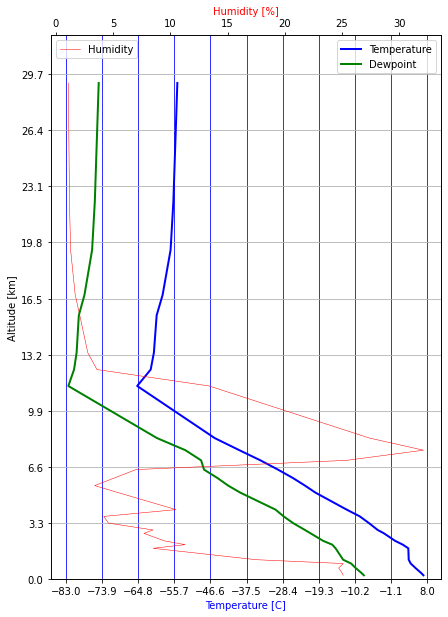

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Max altitude to display in km
max_display_altitude = 32

max_altitude = math.ceil(max_altitude) + 1

altitudes = np.arange(max_altitude)

temperatures = np.empty(max_altitude)
humidities = np.empty(max_altitude)
dewpoints = np.empty(max_altitude)

temperatures.fill(None)
humidities.fill(None)
dewpoints.fill(None)

for row in data:  
  altitude = int(row['Altitude'])

  temperatures[altitude] = float(row['Temperature']) if row['Temperature'] else None
  humidities[altitude] = float(row['Humidity']) if row['Humidity'] else None
  dewpoints[altitude] = float(row['Dewpoint']) if row['Dewpoint'] else None


def calc_tick_distance(min, max):
  val = (max - min) / 10
  return math.floor(val) if abs(val) > 10 else val

fig, temp_ax = plt.subplots()
fig.set_size_inches(7, 10)

plt.yticks(np.arange(0, max_display_altitude + 1, calc_tick_distance(0, max_display_altitude + 1)))
plt.grid(axis = 'y')
plt.ylabel('Altitude [km]')
plt.ylim(0, max_display_altitude)

def draw_temperature_info(ax, values):
  mask = np.isfinite(values)
  values = values[mask]

  x_min = math.floor(min(values))
  x_max = math.ceil(max(values)) + 1
  
  ax.set_xticks(np.arange(x_min, x_max + 1, calc_tick_distance(x_min, x_max)))
  ax.grid(axis = 'x', color = 'blue')
  ax.set_xlabel('Temperature [C]', color = 'blue')

def plot_temperature(ax, values):
  mask = np.isfinite(values)
  values = values[mask]

  ax.plot(values, altitudes[mask] * 0.001, color = 'blue', linewidth = 2, label = 'Temperature')

def plot_dewpoint(ax, values):
  mask = np.isfinite(values)
  values = values[mask]

  ax.plot(values, altitudes[mask] * 0.001, color = 'green', linewidth = 2, label = 'Dewpoint')

def plot_humidity(ax, values):
  mask = np.isfinite(values)
  values = values[mask]

  ax.plot(values, altitudes[mask] * 0.001, color = 'red', linewidth = 0.5, label = 'Humidity')
  ax.set_xlabel('Humidity [%]', color = 'red')
  # ax.grid(axis = 'x', color = 'red')


draw_temperature_info(temp_ax, np.concatenate((temperatures, dewpoints)))
plot_temperature(temp_ax, temperatures)
plot_dewpoint(temp_ax, dewpoints)

hum_ax = temp_ax.twiny()
plot_humidity(hum_ax, humidities)

temp_ax.legend(loc='upper right')
hum_ax.legend(loc='upper left')
plt.show()
